Loading pretrained model MANIQA from /home/msi/.cache/torch/hub/pyiqa/ckpt_koniq10k.pt
Loading pretrained model MUSIQ from /home/msi/.cache/torch/hub/pyiqa/musiq_koniq_ckpt-e95806b9.pth

Loading data and pre-computing average choroid thickness...


Calculating average choroid thickness: 100%|██████████| 348/348 [00:00<00:00, 400.95it/s]


Pre-computed average choroid thickness from dataset: 59 pixels.

Calculating metrics for all images...


Evaluating: 100%|██████████| 348/348 [17:28<00:00,  3.01s/it]



Saving combined results...
Results saved to /home/msi/Documents/IIT-H/src/results/IQA_Test/results_combined_final.csv

Generating visualizations...


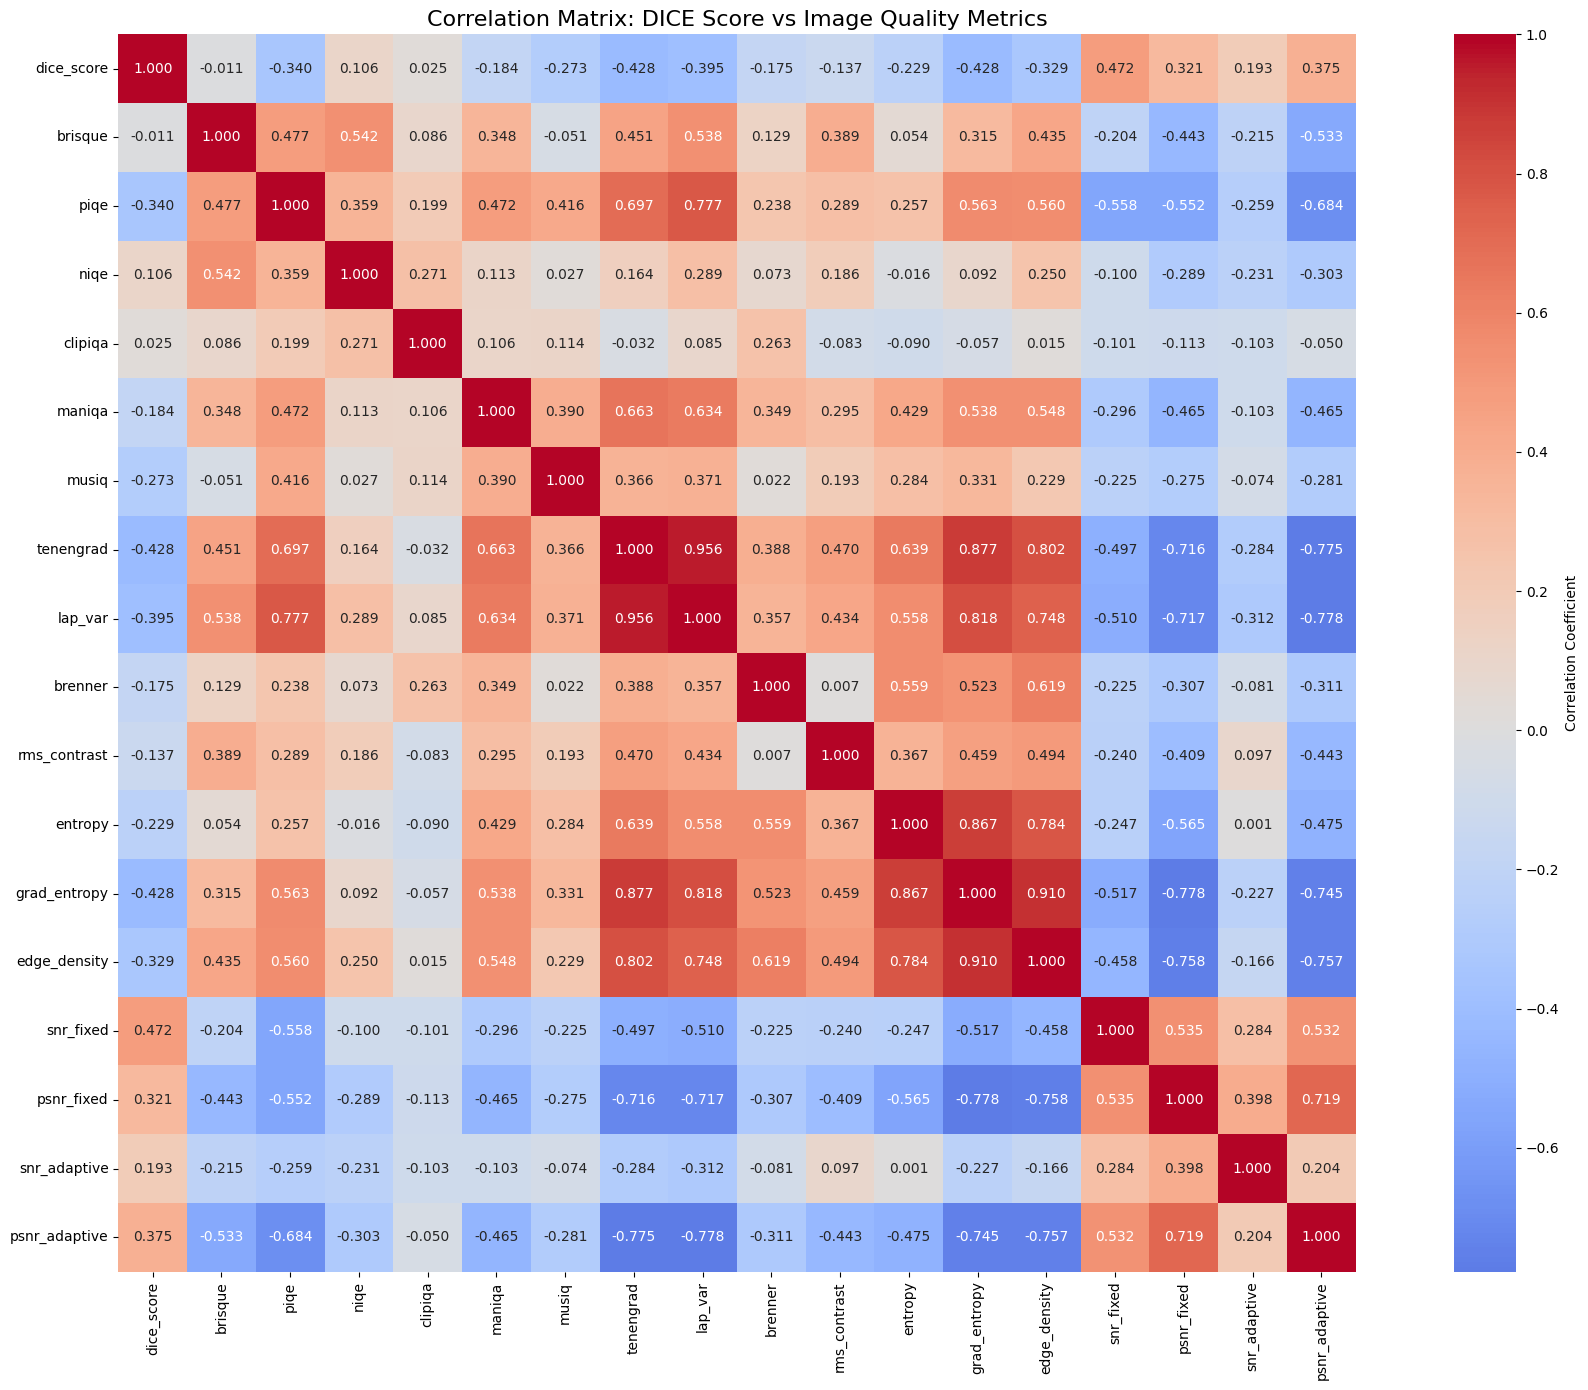

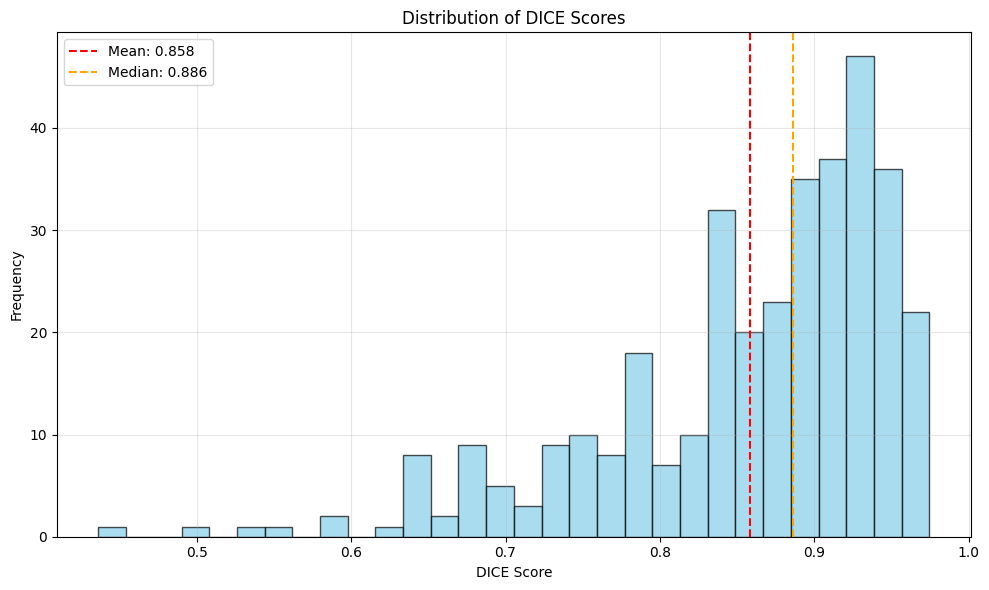

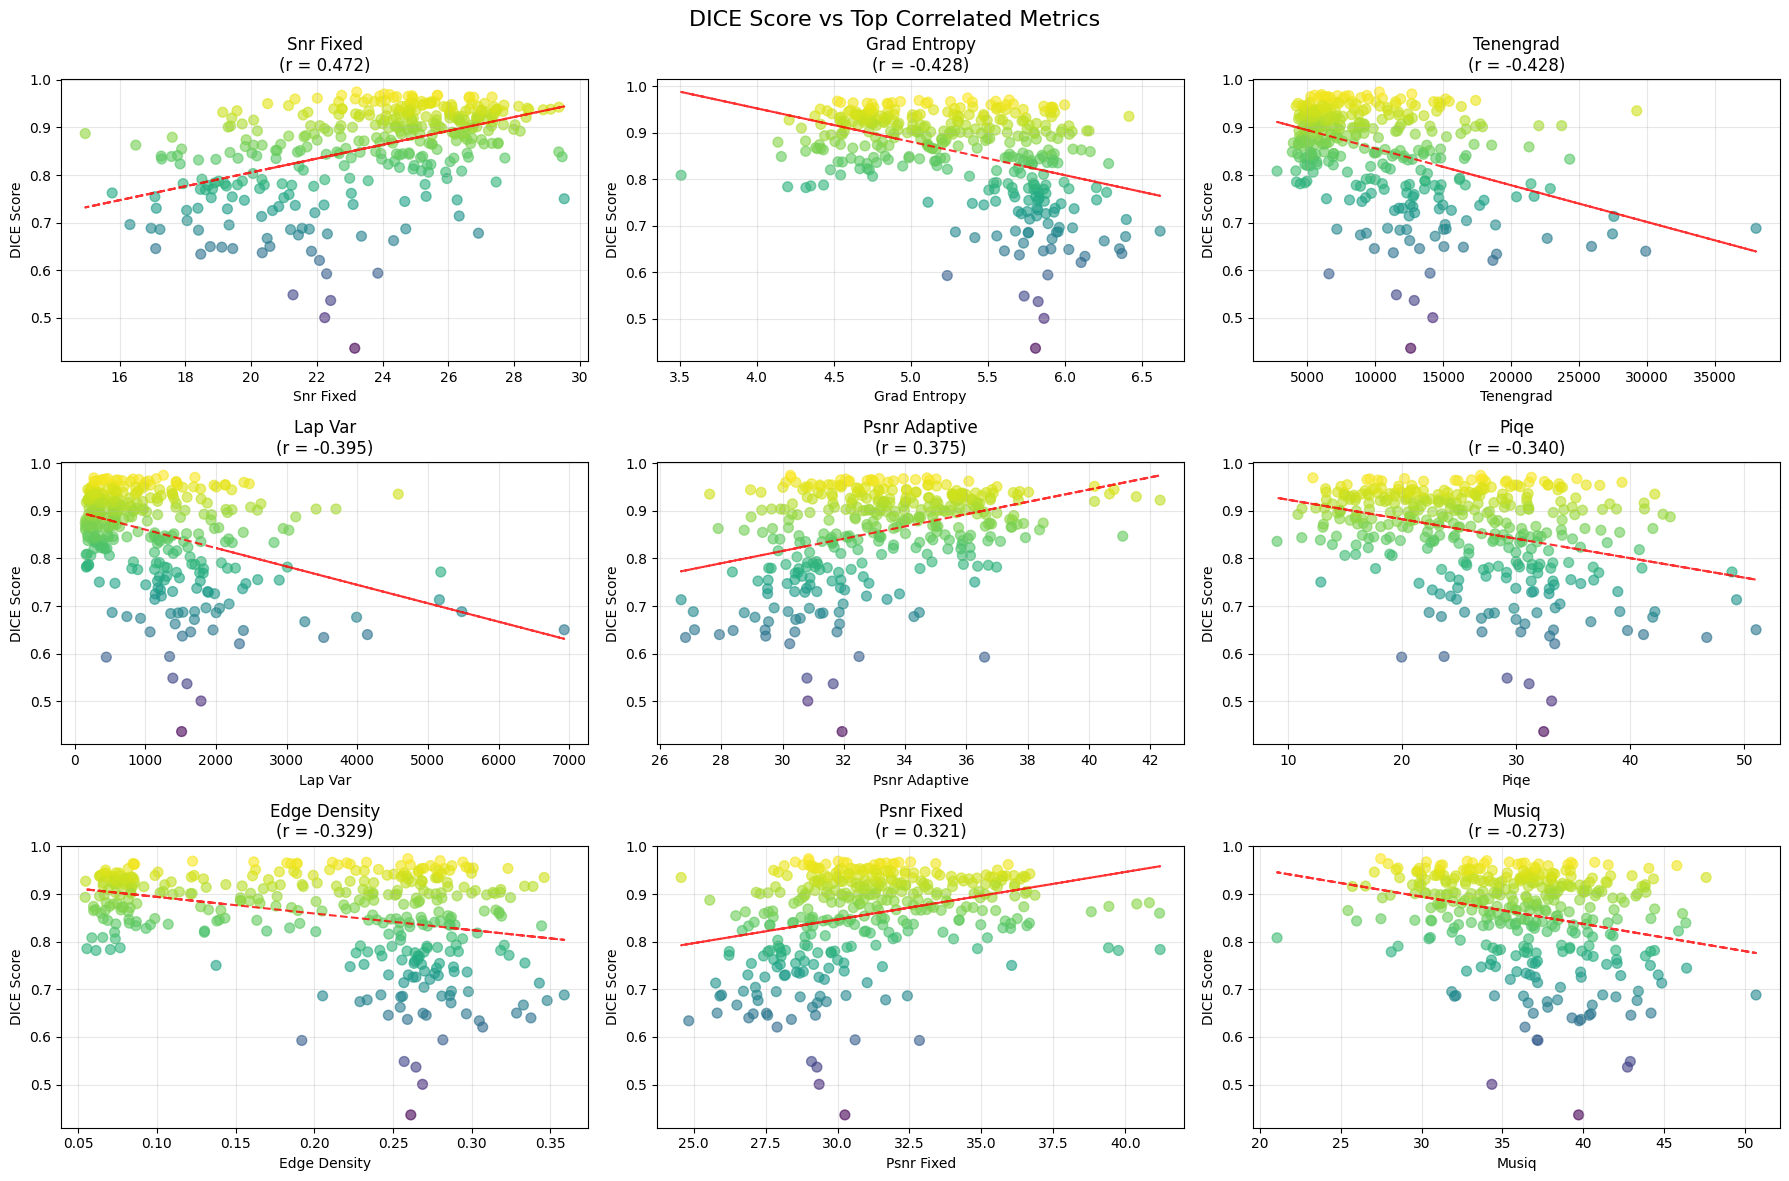

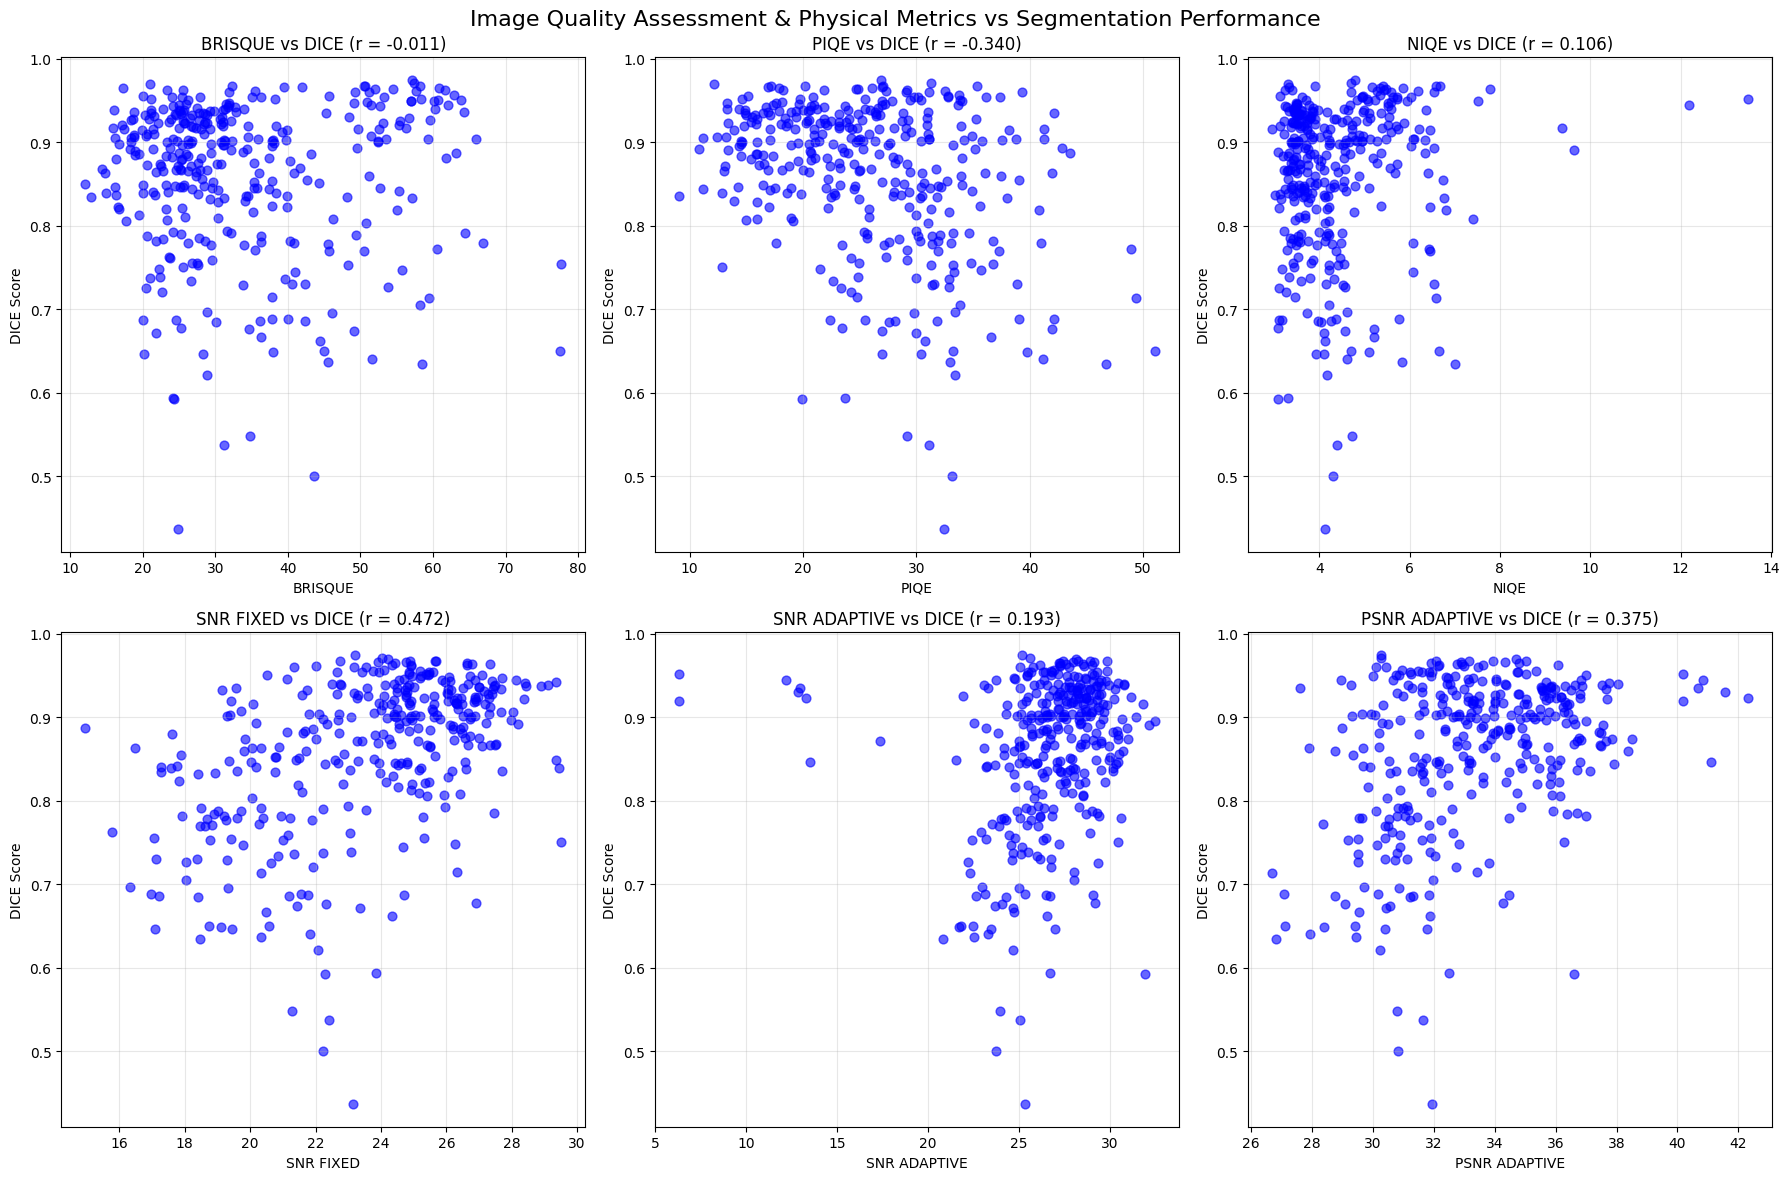


Script execution finished. All metrics calculated and plots saved.


In [ ]:
import os
import csv
import pickle
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pyiqa import create_metric
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import cv2
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, median_filter
import sys

# --- Paths ---
ROOT = r"/home/msi/Documents/IIT-H/"
MODEL_DIR = os.path.join(ROOT,"machine_perception", "unpacked_model", "resunet_generator_100")
ORG_DIR = os.path.join(ROOT, "machine_perception","Training data", "org")
GT_MASK_DIR = os.path.join(ROOT, "machine_perception", "Training data", "gt_mask")
OUT_MASK_ORG = os.path.join(ROOT, "src", "results", "IQA_Test", "predicted_masks")
CSV_PATH_COMBINED = os.path.join(ROOT, "src", "results", "IQA_Test", "results_combined_final.csv")
PLOT_DIR = os.path.join(ROOT, "src", "results", "IQA_Test", "plots")

os.makedirs(OUT_MASK_ORG, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# --- Params ---
GAUSS_SIGMA = 1.0
VALID_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
PAD_MULTIPLE = 16
FIXED_CHOROID_THICKNESS = 40
ADAPTIVE_SMOOTH_SIGMA_TOP = 7
ADAPTIVE_SMOOTH_SIGMA_BOTTOM = 10
MEDIAN_FILTER_SIZE_TOP = 5
MEDIAN_FILTER_SIZE_BOTTOM = 7
THICKNESS_SEARCH_RANGE = 30

# --- Load legacy model state_dict ---
class LegacyReader:
    def __init__(self, folder):
        self.tensor_folder = os.path.join(folder, "data")
    def persistent_load(self, saved_id):
        if isinstance(saved_id, tuple) and saved_id[0] == 'storage':
            _, _, key, _, _ = saved_id
            tensor_file = os.path.join(self.tensor_folder, str(key))
            with open(tensor_file, "rb") as f:
                return torch.FloatStorage.from_buffer(f.read(), byte_order="little")
        raise RuntimeError(f"Unknown persistent ID type: {saved_id}")


sys.path.append(os.path.join(ROOT, "machine_perception"))
from generators.residual_Unet import ResidualUNet
from loss.loss_functions import DiceLoss

pkl_path = os.path.join(MODEL_DIR, "data.pkl")
with open(pkl_path, "rb") as f:
    unpickler = pickle.Unpickler(f)
    unpickler.persistent_load = LegacyReader(MODEL_DIR).persistent_load
    state_dict = unpickler.load()

model = ResidualUNet(in_channels=3, out_channels=1)
model.load_state_dict(state_dict)
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
transform = transforms.ToTensor()
dice_fn = DiceLoss(reduction="none")

# --- IQA Metrics ---
brisque = create_metric('brisque', device=device)
piqe = create_metric('piqe', device=device)
niqe = create_metric('niqe', device=device)
clipiqa = create_metric('clipiqa', device=device)
maniqa = create_metric('maniqa', device=device)
musiq = create_metric('musiq', device=device)

# --- Metric Functions (combined from both files) ---
def get_choroid_edges_from_mask(mask):
    top = np.zeros(mask.shape[1], dtype=np.int32)
    bottom = np.zeros(mask.shape[1], dtype=np.int32)
    for x in range(mask.shape[1]):
        col = mask[:, x]
        ys = np.where(col > 0)[0]
        if len(ys) > 0:
            top[x] = ys[0]
            bottom[x] = ys[-1]
        else:
            top[x] = 0
            bottom[x] = 0
    return top, bottom

def compute_snr_psnr(signal_region, max_val=255):
    if signal_region.size == 0:
        return np.nan, np.nan
    denoised = gaussian_filter(signal_region, sigma=GAUSS_SIGMA)
    x = signal_region.astype(np.float32).flatten()
    x_hat = denoised.astype(np.float32).flatten()
    power_signal = np.mean(x ** 2)
    mse = np.mean((x - x_hat) ** 2)
    snr = 10 * np.log10(power_signal / (mse + 1e-8))
    psnr = 10 * np.log10((max_val ** 2) / (mse + 1e-8))
    return snr, psnr

def find_adaptive_choroid_boundaries(img, avg_choroid_thickness, THICKNESS_SEARCH_RANGE):
    img_h, img_w = img.shape
    blurred_img = gaussian_filter(img.astype(np.float32), sigma=2)
    
    top_boundary_rough = np.zeros(img_w, dtype=np.int32)
    bottom_boundary_rough = np.zeros(img_w, dtype=np.int32)

    search_start_top = int(img_h * 0.4)
    search_end_top = int(img_h * 0.7)
    
    first_col_slice = blurred_img[:, 0][search_start_top:search_end_top]
    if first_col_slice.size > 0:
        top_boundary_rough[0] = search_start_top + np.argmax(first_col_slice)
    else:
        top_boundary_rough[0] = search_start_top

    for x in range(1, img_w):
        prev_boundary = top_boundary_rough[x-1]
        search_min = max(0, prev_boundary - 20)
        search_max = min(img_h, prev_boundary + 20)
        
        col_slice = blurred_img[:, x][search_min:search_max]
        if col_slice.size > 0:
            local_max_y = np.argmax(col_slice)
            top_boundary_rough[x] = search_min + local_max_y
        else:
            top_boundary_rough[x] = top_boundary_rough[x-1]

    for x in range(img_w):
        search_start_y = top_boundary_rough[x]
        search_end_y = min(img_h, top_boundary_rough[x] + avg_choroid_thickness + THICKNESS_SEARCH_RANGE)
        
        choroid_region_intensities = blurred_img[search_start_y:min(img_h, top_boundary_rough[x] + avg_choroid_thickness), x]
        if choroid_region_intensities.size > 0:
            reference_intensity = np.median(choroid_region_intensities)
            threshold = reference_intensity * 0.4 
            
            boundary_found = False
            for y in range(search_start_y + 1, search_end_y):
                if blurred_img[y, x] < threshold and blurred_img[y-1, x] >= threshold:
                    bottom_boundary_rough[x] = y
                    boundary_found = True
                    break
            
            if not boundary_found:
                bottom_boundary_rough[x] = top_boundary_rough[x] + avg_choroid_thickness
        else:
            bottom_boundary_rough[x] = top_boundary_rough[x] + avg_choroid_thickness

    top_boundary_median = median_filter(top_boundary_rough.astype(np.float32), size=MEDIAN_FILTER_SIZE_TOP)
    bottom_boundary_median = median_filter(bottom_boundary_rough.astype(np.float32), size=MEDIAN_FILTER_SIZE_BOTTOM)
    
    top_boundary_smoothed = gaussian_filter(top_boundary_median, sigma=ADAPTIVE_SMOOTH_SIGMA_TOP).astype(np.int32)
    bottom_boundary_smoothed = gaussian_filter(bottom_boundary_median, sigma=ADAPTIVE_SMOOTH_SIGMA_BOTTOM).astype(np.int32)
    
    bottom_boundary_smoothed = np.maximum(bottom_boundary_smoothed, top_boundary_smoothed + 1)
    return top_boundary_smoothed, bottom_boundary_smoothed

def compute_structural_metrics(img_array):
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    grad_mag = np.sqrt(gx**2 + gy**2)

    hist = np.histogram(gray, bins=256, range=(0, 256))[0]
    entropy = -np.sum((p := hist / hist.sum())[p > 0] * np.log2(p[p > 0])) if hist.sum() > 0 else 0
    hist_grad = np.histogram(grad_mag, bins=256)[0]
    grad_entropy = -np.sum((pg := hist_grad / hist_grad.sum())[pg > 0] * np.log2(pg[pg > 0])) if hist_grad.sum() > 0 else 0

    return {
        'tenengrad': np.mean(gx**2 + gy**2),
        'lap_var': cv2.Laplacian(gray, cv2.CV_64F).var(),
        'brenner': np.sum((gray[:-2, :] - gray[2:, :]) ** 2),
        'rms_contrast': np.std(gray),
        'entropy': entropy,
        'grad_entropy': grad_entropy,
        'edge_density': np.mean(cv2.Canny(gray, 50, 150)) / 255.0
    }

def pad_to_multiple(img_tensor, multiple=16):
    _, _, h, w = img_tensor.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    return F.pad(img_tensor, (0, pad_w, 0, pad_h), mode='reflect'), (h, w)

# --- 1. Pre-compute Average Choroid Thickness (from Untitled-6) ---
print("\nLoading data and pre-computing average choroid thickness...")

all_filenames = sorted([f for f in os.listdir(ORG_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
mask_files = [f for f in os.listdir(GT_MASK_DIR) if f.lower().endswith(VALID_EXTS)]
thicknesses = []
for fname in tqdm(mask_files, desc="Calculating average choroid thickness"):
    path = os.path.join(GT_MASK_DIR, fname)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    top, bottom = get_choroid_edges_from_mask((mask > 127).astype(np.uint8))
    thickness = bottom - top
    thickness = thickness[thickness > 0]
    if thickness.size > 0:
        thicknesses.extend(thickness.tolist())

if thicknesses:
    avg_choroid_thickness = int(np.mean(thicknesses))
    print(f"Pre-computed average choroid thickness from dataset: {avg_choroid_thickness} pixels.")
else:
    avg_choroid_thickness = 100

# --- 2. Main Evaluation Loop: Calculate All Metrics ---
print("\nCalculating metrics for all images...")
results = []
for fname in tqdm(all_filenames, desc="Evaluating"):
    img_path = os.path.join(ORG_DIR, fname)
    gt_path = os.path.join(GT_MASK_DIR, fname)
    if not os.path.exists(gt_path):
        continue

    img = Image.open(img_path).convert("RGB")
    img_gray = np.array(img.convert("L"))
    gt = Image.open(gt_path).convert("L")
    gt_array = (np.array(gt) > 127).astype(np.uint8)
    
    # --- Segmentation and IQA/Structural Metrics (from Untitled-5) ---
    input_tensor = transform(img).unsqueeze(0).to(device)
    input_tensor_padded, (h, w) = pad_to_multiple(input_tensor)
    
    with torch.no_grad():
        output = model(input_tensor_padded)
        output = output[..., :h, :w]
        pred_mask = output.squeeze().cpu().numpy()

    pred_bin = (pred_mask > 0.5).astype(np.uint8)
    Image.fromarray(pred_bin * 255).save(os.path.join(OUT_MASK_ORG, f"{os.path.splitext(fname)[0]}.png"))

    gt_tensor = torch.from_numpy(gt_array).float().unsqueeze(0).unsqueeze(0)
    if gt_tensor.sum() == 0 and pred_bin.sum() == 0:
        dice = 1.0
    elif gt_tensor.sum() == 0 or pred_bin.sum() == 0:
        dice = 0.0
    else:
        dice = 1.0 - dice_fn(torch.from_numpy(pred_bin).unsqueeze(0).unsqueeze(0).float(), gt_tensor).item()

    input_rgb = transform(img).unsqueeze(0).to(device)
    
    metrics = {
        'brisque': float(brisque(input_rgb).item()),
        'piqe': float(piqe(input_rgb).item()),
        'niqe': float(niqe(input_rgb).item()),
        'clipiqa': float(clipiqa(input_rgb).item()),
        'maniqa': float(maniqa(input_rgb).item()),
        'musiq': float(musiq(input_rgb).item())
    }
    
    structural = compute_structural_metrics(np.array(img))

    # --- NEW SNR/PSNR Metrics (from Untitled-6) ---
    # Fixed Band
    padded_h, padded_w = input_tensor_padded.shape[2:]
    fixed_top = padded_h // 2 - FIXED_CHOROID_THICKNESS // 2
    fixed_bottom = padded_h // 2 + FIXED_CHOROID_THICKNESS // 2
    fixed_band = img_gray[fixed_top:fixed_bottom, :]
    snr_fixed, psnr_fixed = compute_snr_psnr(fixed_band)

    # Adaptive Band
    adaptive_top, adaptive_bottom = find_adaptive_choroid_boundaries(img_gray, avg_choroid_thickness, THICKNESS_SEARCH_RANGE)
    adaptive_band_region = np.zeros_like(img_gray, dtype=np.uint8)
    for x in range(img_gray.shape[1]):
        t = adaptive_top[x]
        b = adaptive_bottom[x]
        if 0 <= t < b < img_gray.shape[0]:
            adaptive_band_region[t:b, x] = img_gray[t:b, x]
    adaptive_band_region = adaptive_band_region[adaptive_band_region > 0]
    snr_adaptive, psnr_adaptive = compute_snr_psnr(adaptive_band_region)

    results.append([
        os.path.splitext(fname)[0], dice,
        metrics['brisque'], metrics['piqe'], metrics['niqe'],
        metrics['clipiqa'], metrics['maniqa'], metrics['musiq'],
        structural['tenengrad'], structural['lap_var'], structural['brenner'],
        structural['rms_contrast'], structural['entropy'], structural['grad_entropy'],
        structural['edge_density'],
        snr_fixed, psnr_fixed, snr_adaptive, psnr_adaptive
    ])

# --- 3. Save Results ---
print("\nSaving combined results...")
header = [
    "image_name", "dice_score", "brisque", "piqe", "niqe",
    "clipiqa", "maniqa", "musiq",
    "tenengrad", "lap_var", "brenner", "rms_contrast",
    "entropy", "grad_entropy", "edge_density",
    "snr_fixed", "psnr_fixed", "snr_adaptive", "psnr_adaptive"
]

with open(CSV_PATH_COMBINED, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(results)

print(f"Results saved to {CSV_PATH_COMBINED}")

# --- 4. Visualizations ---
print("\nGenerating visualizations...")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# 4.1. Correlation Matrix Heatmap
plt.figure(figsize=(20, 14))
metric_cols = [
    "dice_score", "brisque", "piqe", "niqe", "clipiqa", "maniqa", "musiq",
    "tenengrad", "lap_var", "brenner", "rms_contrast", "entropy",
    "grad_entropy", "edge_density",
    "snr_fixed", "psnr_fixed", "snr_adaptive", "psnr_adaptive"
]

df_results = pd.DataFrame(results, columns=header)
corr_matrix = df_results[metric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
           square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix: DICE Score vs Image Quality Metrics', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "correlation_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()

# 4.2. DICE Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(df_results['dice_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df_results['dice_score'].mean(), color='red', linestyle='--',
           label=f'Mean: {df_results["dice_score"].mean():.3f}')
plt.axvline(df_results['dice_score'].median(), color='orange', linestyle='--',
           label=f'Median: {df_results["dice_score"].median():.3f}')
plt.xlabel('DICE Score')
plt.ylabel('Frequency')
plt.title('Distribution of DICE Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "dice_distribution.png"), dpi=300, bbox_inches='tight')
plt.show()

# 4.3. Scatter plots: DICE vs top correlated metrics
iqa_metrics = ["brisque", "piqe", "niqe", "clipiqa", "maniqa", "musiq"]
structural_metrics = [
    "tenengrad", "lap_var", "brenner", "rms_contrast",
    "entropy", "grad_entropy", "edge_density",
    "snr_fixed", "psnr_fixed", "snr_adaptive", "psnr_adaptive"
]

dice_corrs = corr_matrix['dice_score'].abs().sort_values(ascending=False)[1:]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

top_metrics = dice_corrs.head(9).index
for i, metric in enumerate(top_metrics):
    ax = axes[i]
    scatter = ax.scatter(df_results[metric], df_results['dice_score'], alpha=0.6, c=df_results['dice_score'],
                        cmap='viridis', s=50)

    z = np.polyfit(df_results[metric], df_results['dice_score'], 1)
    p = np.poly1d(z)
    ax.plot(df_results[metric], p(df_results[metric]), "r--", alpha=0.8)

    corr_val = corr_matrix.loc['dice_score', metric]
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_ylabel('DICE Score')
    ax.set_title(f'{metric.replace("_", " ").title()}\n(r = {corr_val:.3f})')
    ax.grid(True, alpha=0.3)

plt.suptitle('DICE Score vs Top Correlated Metrics', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "dice_vs_top_metrics.png"), dpi=300, bbox_inches='tight')
plt.show()

# 4.4. Performance vs Quality scatter (IQA and new SNR/PSNR metrics)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

all_metrics_to_plot = iqa_metrics[:3] + ["snr_fixed", "snr_adaptive", "psnr_adaptive"]

for i, metric in enumerate(all_metrics_to_plot):
    ax = axes[i]
    ax.scatter(df_results[metric], df_results['dice_score'], alpha=0.6, c='blue', s=40)

    corr_val = df_results[metric].corr(df_results['dice_score'])
    ax.set_xlabel(metric.upper().replace('_', ' '))
    ax.set_ylabel('DICE Score')
    ax.set_title(f'{metric.upper().replace("_", " ")} vs DICE (r = {corr_val:.3f})')
    ax.grid(True, alpha=0.3)

plt.suptitle('Image Quality Assessment & Physical Metrics vs Segmentation Performance', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "iqa_physical_vs_dice.png"), dpi=300, bbox_inches='tight')
plt.show()

print("\nScript execution finished. All metrics calculated and plots saved.")


--- Starting Performance-Based Fairness Analysis ---

--- Analysis for Grouping: Dice Group ---

DICE Statistics per Bin:
  dice_group      mean       std        CV
0      Bin_1  0.750676  0.080107  0.106713
1      Bin_2  0.883387  0.021526  0.024367
2      Bin_3  0.940879  0.015387  0.016354

Performance Gap: 0.1902

Kolmogorov-Smirnov Test between bins:
  - Bin_1 vs Bin_2: KS Stat = 1.0000, p-value = 0.0000
  - Bin_1 vs Bin_3: KS Stat = 1.0000, p-value = 0.0000
  - Bin_2 vs Bin_3: KS Stat = 1.0000, p-value = 0.0000

Average Image Metrics per DICE Bin:
  dice_group   entropy  rms_contrast  snr_adaptive      niqe
0      Bin_1  6.714626     58.484043     26.038574  4.219761
1      Bin_2  6.622629     56.670702     27.277079  4.343362
2      Bin_3  6.446698     57.554622     26.783261  4.649705

--- Starting Fairness Visualizations ---


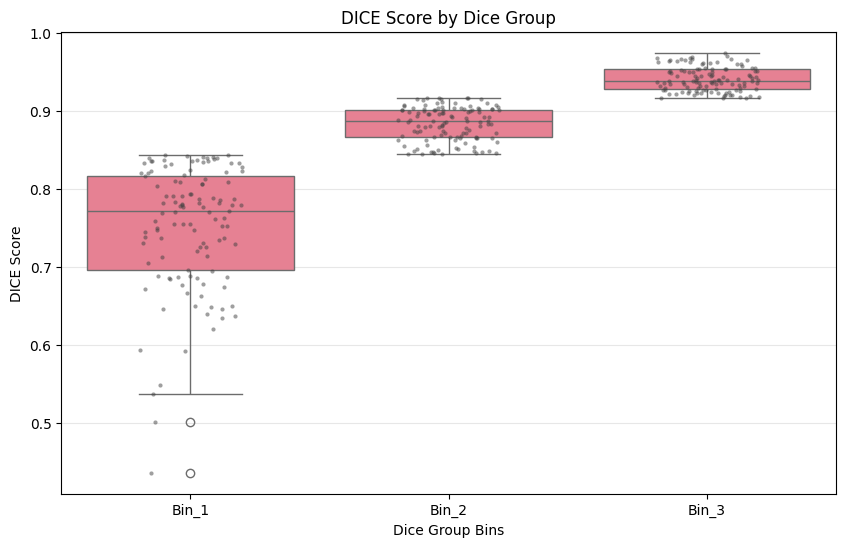

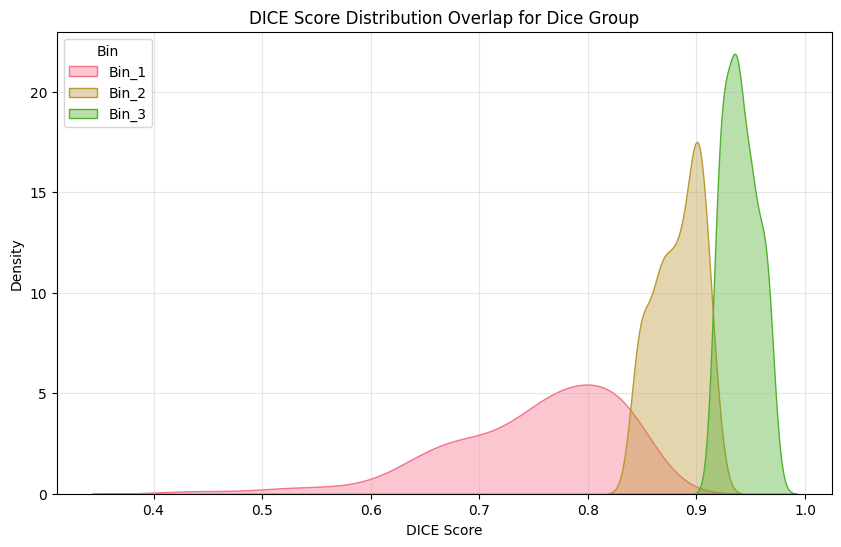


All performance-based fairness metrics and image metric summaries computed and plots saved.


In [33]:
# --- 5. Performance-Based Fairness Analysis with Image Metric Summary ---
from scipy.stats import ks_2samp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("\n--- Starting Performance-Based Fairness Analysis ---")

# Reload CSV
df_results = pd.read_csv(CSV_PATH_COMBINED)

# --- Define DICE-Based Subgroups ---
NUM_BINS = 3
df_results['dice_group'] = pd.qcut(df_results['dice_score'], 
                                   q=NUM_BINS, 
                                   labels=[f'Bin_{i+1}' for i in range(NUM_BINS)])

performance_metric = 'dice_score'
image_metrics = ['entropy', 'rms_contrast', 'snr_adaptive', 'niqe']  # metrics to summarize
grouping_variables = ['dice_group']

for group_var in grouping_variables:
    print(f"\n--- Analysis for Grouping: {group_var.replace('_', ' ').title()} ---")
    
    # --- Performance Stats ---
    group_stats = df_results.groupby(group_var, observed=False)[performance_metric].agg(['mean', 'std']).reset_index()
    group_stats['CV'] = group_stats['std'] / group_stats['mean']
    print("\nDICE Statistics per Bin:")
    print(group_stats)
    
    max_mean = group_stats['mean'].max()
    min_mean = group_stats['mean'].min()
    performance_gap = max_mean - min_mean
    print(f"\nPerformance Gap: {performance_gap:.4f}")
    
    # --- KS Test ---
    unique_bins = group_stats[group_var].unique()
    print("\nKolmogorov-Smirnov Test between bins:")
    for i in range(len(unique_bins)):
        for j in range(i + 1, len(unique_bins)):
            bin_a_data = df_results[df_results[group_var] == unique_bins[i]][performance_metric]
            bin_b_data = df_results[df_results[group_var] == unique_bins[j]][performance_metric]
            if len(bin_a_data) > 1 and len(bin_b_data) > 1:
                ks_stat, p_value = ks_2samp(bin_a_data, bin_b_data)
                print(f"  - {unique_bins[i]} vs {unique_bins[j]}: KS Stat = {ks_stat:.4f}, p-value = {p_value:.4f}")
    
    # --- Image Quality Metrics per DICE Bin ---
    metric_summary = df_results.groupby(group_var, observed=False)[image_metrics].mean().reset_index()
    print("\nAverage Image Metrics per DICE Bin:")
    print(metric_summary)

print("\n--- Starting Fairness Visualizations ---")
for group_var in grouping_variables:
    # Boxplot of DICE
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_var, y=performance_metric, data=df_results, order=sorted(df_results[group_var].unique()))
    sns.stripplot(x=group_var, y=performance_metric, data=df_results, color=".25", jitter=0.2, size=3, alpha=0.5, order=sorted(df_results[group_var].unique()))
    plt.title(f'DICE Score by {group_var.replace("_", " ").title()}')
    plt.xlabel(f'{group_var.replace("_", " ").title()} Bins')
    plt.ylabel('DICE Score')
    plt.grid(True, axis='y', alpha=0.3)
    plt.savefig(os.path.join(PLOT_DIR, f"boxplot_dice_by_{group_var}.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # KDE Distribution
    plt.figure(figsize=(10, 6))
    for bin_name in sorted(df_results[group_var].unique()):
        subset = df_results[df_results[group_var] == bin_name]
        if not subset.empty:
            sns.kdeplot(subset[performance_metric], label=bin_name, fill=True, alpha=0.4)
    plt.title(f'DICE Score Distribution Overlap for {group_var.replace("_", " ").title()}')
    plt.xlabel('DICE Score')
    plt.ylabel('Density')
    plt.legend(title='Bin')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(PLOT_DIR, f"kdeplot_dice_by_{group_var}.png"), dpi=300, bbox_inches='tight')
    plt.show()

print("\nAll performance-based fairness metrics and image metric summaries computed and plots saved.")


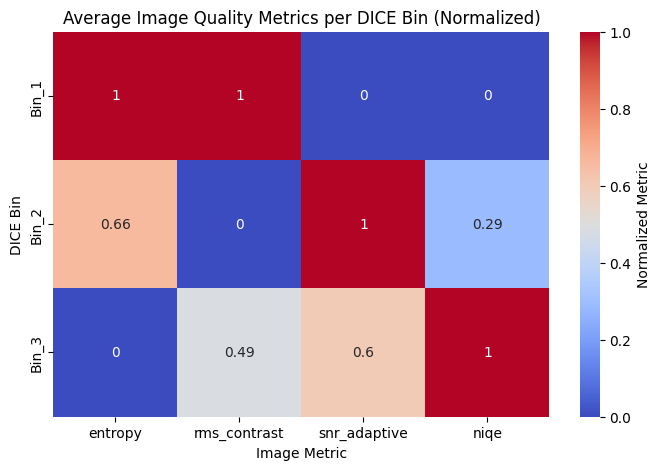

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics to visualize
image_metrics = ['entropy', 'rms_contrast', 'snr_adaptive', 'niqe']

# Compute mean of image metrics per DICE bin
metric_summary = df_results.groupby('dice_group', observed=False)[image_metrics].mean()

# Optional: normalize values per metric for better visual comparison
metric_summary_norm = (metric_summary - metric_summary.min()) / (metric_summary.max() - metric_summary.min())

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(metric_summary_norm, annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Metric'})
plt.title('Average Image Quality Metrics per DICE Bin (Normalized)')
plt.xlabel('Image Metric')
plt.ylabel('DICE Bin')
plt.show()
